In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.probability import FreqDist
import string


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv


In [ ]:
import io

train_df = pd.read_csv(io.BytesIO(uploaded['train.csv']))
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# Preprocessing

In [ ]:
sample_tweet = train_df['text'].iloc[203]
sample_tweet

'Twelve feared killed in Pakistani air ambulance helicopter crash http://t.co/TH9YwBbeet #worldNews'

In [ ]:
import re
tweet = train_df['text']

for i in range(len(train_df)):
  tweet[i] = re.sub('&amp', '&', tweet[i]) #turns '&amp to &'
  tweet[i] = re.sub(r'http\S+', '', tweet[i]) #removes links
  tweet[i] = re.sub(r'(@.*?)[\s]', ' ', tweet[i]) #removes mentions
  tweet[i] = re.sub(r'\s+', ' ', tweet[i]).strip() #removes trailing whitespace

In [ ]:
print('Sample tweet:\n')
print(sample_tweet)
print('Cleaned tweet:\n')
print(train_df['text'].iloc[203])

Sample tweet:

Twelve feared killed in Pakistani air ambulance helicopter crash http://t.co/TH9YwBbeet #worldNews
Cleaned tweet:

Twelve feared killed in Pakistani air ambulance helicopter crash #worldNews


In [ ]:
stop_words = set(stopwords.words('english'))
stop_words.update(['http','https','via','...','..', "'s","'m"])
special_chars = set(string.punctuation)
lemmatizer = WordNetLemmatizer()

preprocessed_data = []
labels = []

for i in range(len(train_df)):
  tweet = train_df['text'].iloc[i]
  label = train_df['target'].iloc[i]
  tokens = word_tokenize(tweet.lower())
  filtered_tokens = [token for token in tokens if token.casefold() not in stop_words]
  filtered_tokens = [token for token in filtered_tokens if token not in special_chars]
  lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
  preprocessed_tweet = ' '.join(lemmatized_tokens)
  preprocessed_data.append(preprocessed_tweet)
  labels.append(label)

In [ ]:
print('Sample tweet:\n')
print(sample_tweet)
print('\nCleaned tweet:\n')
print(preprocessed_data[203])

Sample tweet:

Twelve feared killed in Pakistani air ambulance helicopter crash http://t.co/TH9YwBbeet #worldNews

Cleaned tweet:

twelve feared killed pakistani air ambulance helicopter crash worldnews


# Models

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(preprocessed_data, labels, test_size=0.2, random_state=101)

In [ ]:
print('Number of disaster tweets in the training set: ')
print(np.array([y_train]).sum())
print('Number of nondisaster tweets in the training set: ')
print(len(y_train)-np.array([y_train]).sum())

Number of disaster tweets in the training set: 
2640
Number of nondisaster tweets in the training set: 
3450


# SVM

In [ ]:
pipeline = Pipeline([('transformer', Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer())])),
 	('svc', SVC())])

parameters = {'transformer__vect__ngram_range': ((1,1),(1,2)),
              'transformer__tfidf__use_idf': (True, False),
               'svc__C':[0.01, 0.1, 1, 10],
               'svc__kernel':['linear', 'rbf','poly'],
               'svc__degree':[1,2,3]}

svm = GridSearchCV(pipeline,parameters,scoring='f1')
svm.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('transformer',
                                        Pipeline(steps=[('vect',
                                                         CountVectorizer()),
                                                        ('tfidf',
                                                         TfidfTransformer())])),
                                       ('svc', SVC())]),
             param_grid={'svc__C': [0.01, 0.1, 1, 10], 'svc__degree': [1, 2, 3],
                         'svc__kernel': ['linear', 'rbf', 'poly'],
                         'transformer__tfidf__use_idf': (True, False),
                         'transformer__vect__ngram_range': ((1, 1), (1, 2))},
             scoring='f1')

In [ ]:
svm.best_params_

{'svc__C': 1,
 'svc__degree': 1,
 'svc__kernel': 'linear',
 'transformer__tfidf__use_idf': True,
 'transformer__vect__ngram_range': (1, 2)}

In [ ]:
svm_train_preds = svm.predict(X_train)
print(classification_report(y_train,svm_train_preds))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      3450
           1       0.98      0.94      0.96      2640

    accuracy                           0.97      6090
   macro avg       0.97      0.96      0.97      6090
weighted avg       0.97      0.97      0.97      6090



In [ ]:
svm_val_preds = svm.predict(X_test)
print(classification_report(y_test,svm_val_preds))

              precision    recall  f1-score   support

           0       0.81      0.84      0.82       892
           1       0.76      0.72      0.74       631

    accuracy                           0.79      1523
   macro avg       0.78      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

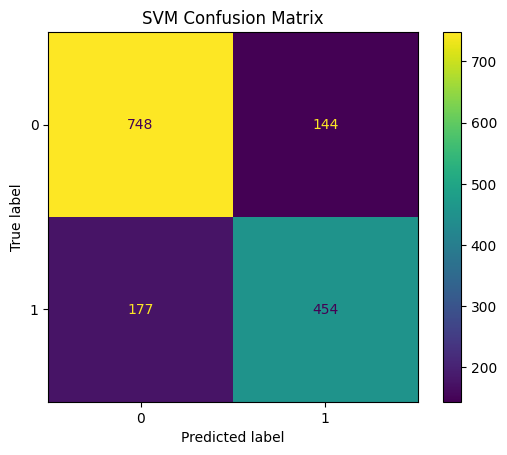

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test,svm_val_preds), display_labels=svm.classes_).plot()
plt.title('SVM Confusion Matrix')
plt.savefig('svm_conf_matrix.png', dpi=200, bbox_inches='tight');

from google.colab import files
files.download("svm_conf_matrix.png")

In [ ]:
svm_final = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,2))), ('svc',SVC(C=1,kernel='linear'))])
svm_final.fit(preprocessed_data, labels)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('svc', SVC(C=1, kernel='linear'))])

# Logistic Regression

In [ ]:
pipeline = Pipeline([('transformer', Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer())])),
 	('scaler',StandardScaler(with_mean=False)), ('log', LogisticRegression(solver='liblinear'))])

parameters = {'transformer__tfidf__use_idf': (True, False),
               'log__C':[0.01, 0.1, 1, 10],
               'log__penalty':['l1', 'l2', 'elasticnet', None],
               }

log_model = GridSearchCV(pipeline,parameters, scoring='f1')
log_model.fit(X_train,y_train)

In [ ]:
log_model.best_params_

{'log__C': 0.01, 'log__penalty': 'l2', 'transformer__tfidf__use_idf': False}

In [ ]:
log_train_preds = log_model.predict(X_train)
print(classification_report(y_train,log_train_preds))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3450
           1       0.99      0.98      0.98      2640

    accuracy                           0.98      6090
   macro avg       0.99      0.98      0.98      6090
weighted avg       0.98      0.98      0.98      6090



In [ ]:
log_val_preds = log_model.predict(X_test)
print(classification_report(y_test,log_val_preds))

              precision    recall  f1-score   support

           0       0.77      0.78      0.78       892
           1       0.68      0.68      0.68       631

    accuracy                           0.74      1523
   macro avg       0.73      0.73      0.73      1523
weighted avg       0.74      0.74      0.74      1523



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

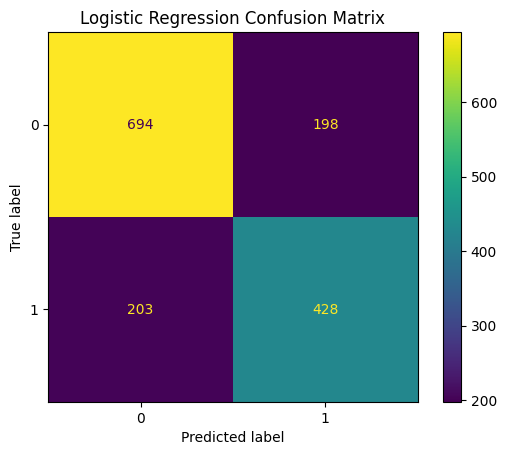

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test,log_val_preds), display_labels=log_model.classes_).plot()
plt.title('Logistic Regression Confusion Matrix')
plt.savefig('log_conf_matrix.png', dpi=200, bbox_inches='tight');

from google.colab import files
files.download("log_conf_matrix.png")

In [ ]:
log_final = Pipeline([('tfidf', TfidfVectorizer(use_idf=False)), ('scaler',StandardScaler(with_mean=False)),
 ('log', LogisticRegression(C=0.01,penalty='l2', solver='liblinear'))])
log_final.fit(preprocessed_data, labels)

Pipeline(steps=[('tfidf', TfidfVectorizer(use_idf=False)),
                ('scaler', StandardScaler(with_mean=False)),
                ('log', LogisticRegression(C=0.01, solver='liblinear'))])

# KNN

In [ ]:
pipeline = Pipeline([('transformer', Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer())])),
 	 ('knn', KNeighborsClassifier())])

parameters = {'transformer__vect__ngram_range': ((1,1),(1,2)),
              'transformer__tfidf__use_idf': (True, False),
               'knn__n_neighbors':[1,2,3,5,10,15,25],
               'knn__weights':['uniform','distance'],
               }

knn = GridSearchCV(pipeline,parameters, scoring='f1')
knn.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('transformer',
                                        Pipeline(steps=[('vect',
                                                         CountVectorizer()),
                                                        ('tfidf',
                                                         TfidfTransformer())])),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 2, 3, 5, 10, 15, 25],
                         'knn__weights': ['uniform', 'distance'],
                         'transformer__tfidf__use_idf': (True, False),
                         'transformer__vect__ngram_range': ((1, 1), (1, 2))},
             scoring='f1')

In [ ]:
knn.best_params_

{'knn__n_neighbors': 25,
 'knn__weights': 'distance',
 'transformer__tfidf__use_idf': True,
 'transformer__vect__ngram_range': (1, 2)}

In [ ]:
knn_preds_train = knn.predict(X_train)
print(classification_report(y_train,knn_preds_train))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3450
           1       1.00      0.97      0.99      2640

    accuracy                           0.99      6090
   macro avg       0.99      0.99      0.99      6090
weighted avg       0.99      0.99      0.99      6090



In [ ]:
knn_preds_val = knn.predict(X_test)
print(classification_report(y_test,knn_preds_val))

              precision    recall  f1-score   support

           0       0.80      0.84      0.82       892
           1       0.76      0.70      0.73       631

    accuracy                           0.79      1523
   macro avg       0.78      0.77      0.78      1523
weighted avg       0.78      0.79      0.78      1523



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

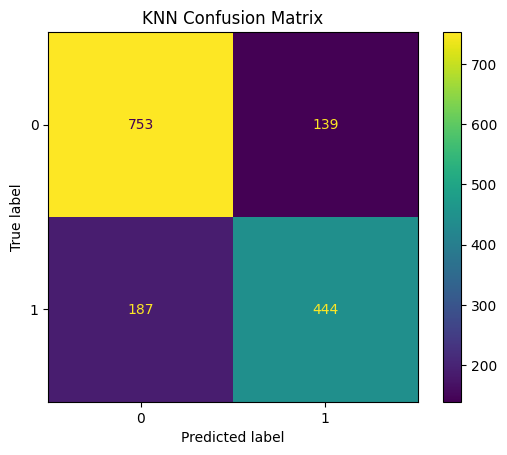

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test,knn_preds_val), display_labels=knn.classes_).plot()
plt.title('KNN Confusion Matrix')
plt.savefig('knn_conf_matrix.png', dpi=200, bbox_inches='tight');

from google.colab import files
files.download("knn_conf_matrix.png")

In [ ]:
knn_final = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,2))),
 ('knn', KNeighborsClassifier(n_neighbors=25, weights='distance'))])
knn_final.fit(preprocessed_data, labels)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('knn',
                 KNeighborsClassifier(n_neighbors=25, weights='distance'))])

#Naive Bayes

In [ ]:
pipeline = Pipeline([('transformer', Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer())])),
 	('nb', MultinomialNB())])

parameters = {'transformer__vect__ngram_range': ((1,1),(1,2)),
              'transformer__tfidf__use_idf': (True, False)
              }

nb = GridSearchCV(pipeline, parameters, scoring='f1')
nb.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('transformer',
                                        Pipeline(steps=[('vect',
                                                         CountVectorizer()),
                                                        ('tfidf',
                                                         TfidfTransformer())])),
                                       ('nb', MultinomialNB())]),
             param_grid={'transformer__tfidf__use_idf': (True, False),
                         'transformer__vect__ngram_range': ((1, 1), (1, 2))},
             scoring='f1')

In [ ]:
nb.best_params_

{'transformer__tfidf__use_idf': False,
 'transformer__vect__ngram_range': (1, 1)}

In [ ]:
nb_preds_train = nb.predict(X_train)
print(classification_report(y_train,nb_preds_train))

              precision    recall  f1-score   support

           0       0.85      0.96      0.90      3450
           1       0.93      0.78      0.85      2640

    accuracy                           0.88      6090
   macro avg       0.89      0.87      0.87      6090
weighted avg       0.89      0.88      0.88      6090



In [ ]:
nb_preds_val = nb.predict(X_test)
print(classification_report(y_test,nb_preds_val))

              precision    recall  f1-score   support

           0       0.79      0.88      0.84       892
           1       0.81      0.68      0.74       631

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.79      1523
weighted avg       0.80      0.80      0.80      1523



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

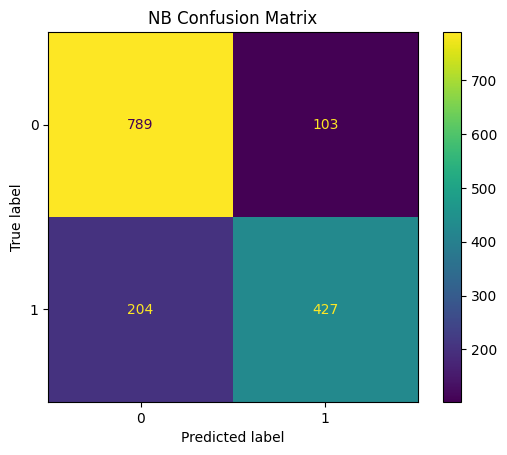

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test,nb_preds_val), display_labels=nb.classes_).plot()
plt.title('NB Confusion Matrix')
plt.savefig('NB_conf_matrix.png', dpi=200, bbox_inches='tight');

from google.colab import files
files.download("NB_conf_matrix.png")

In [ ]:
nbb_final = Pipeline([('tfidf', TfidfVectorizer(use_idf=False)),
 ('nb', MultinomialNB())])
nbb_final.fit(preprocessed_data, labels)

Pipeline(steps=[('tfidf', TfidfVectorizer(use_idf=False)),
                ('nb', MultinomialNB())])

# Random Forests

In [ ]:
pipeline = Pipeline([('transformer', Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer())])),
 	('rf', RandomForestClassifier(random_state=101))])

parameters = {'transformer__vect__ngram_range': ((1,1),(1,2)),
              'transformer__tfidf__use_idf': (True, False),
              'rf__n_estimators':[100,500,1000,1500],
              'rf__max_depth':[2,3,4,5],
             'rf__max_features':[1000,3000,5000,None] }

rf = GridSearchCV(pipeline, parameters, scoring='f1')
rf.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('transformer',
                                        Pipeline(steps=[('vect',
                                                         CountVectorizer()),
                                                        ('tfidf',
                                                         TfidfTransformer())])),
                                       ('rf',
                                        RandomForestClassifier(random_state=101))]),
             param_grid={'rf__max_depth': [2, 3, 4, 5],
                         'rf__max_features': [1000, 3000, 5000, None],
                         'rf__n_estimators': [100, 500, 1000, 1500],
                         'transformer__tfidf__use_idf': (True, False),
                         'transformer__vect__ngram_range': ((1, 1), (1, 2))},
             scoring='f1')

In [ ]:
rf.best_params_

{'rf__max_depth': 5,
 'rf__max_features': 1000,
 'rf__n_estimators': 100,
 'transformer__tfidf__use_idf': True,
 'transformer__vect__ngram_range': (1, 1)}

In [ ]:
rf_preds_train = rf.predict(X_train)
print(classification_report(y_train,rf_preds_train))

              precision    recall  f1-score   support

           0       0.64      0.98      0.77      3450
           1       0.92      0.27      0.42      2640

    accuracy                           0.67      6090
   macro avg       0.78      0.63      0.60      6090
weighted avg       0.76      0.67      0.62      6090



In [ ]:
rf_preds_val = rf.predict(X_test)
print(classification_report(y_test,rf_preds_val))

              precision    recall  f1-score   support

           0       0.65      0.97      0.78       892
           1       0.88      0.26      0.40       631

    accuracy                           0.68      1523
   macro avg       0.76      0.61      0.59      1523
weighted avg       0.74      0.68      0.62      1523



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

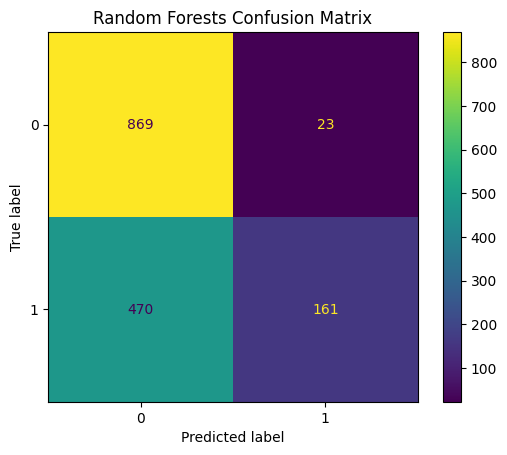

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test,rf_preds_val), display_labels=rf.classes_).plot()
plt.title('Random Forests Confusion Matrix')
plt.savefig('RF_conf_matrix.png', dpi=200, bbox_inches='tight');

from google.colab import files
files.download("RF_conf_matrix.png")

In [ ]:
rf_final = Pipeline([('tfidf', TfidfVectorizer()),
 ('rf', RandomForestClassifier(max_features=1000, n_estimators = 100, max_depth=5, random_state=101))])
rf_final.fit(preprocessed_data, labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('rf',
                 RandomForestClassifier(max_depth=5, max_features=1000,
                                        random_state=101))])

#XGBoost

In [ ]:
pipeline = Pipeline([('transformer', Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer())])),
 	('xgbst', XGBClassifier(tree_method = 'hist', device='cuda', random_state=101))])

parameters = {'transformer__tfidf__use_idf': (True, False),
              'xgbst__n_estimators':[100,500,1000],
              'xgbst__max_depth':[2,3,4,5],
              'xgbst__learning_rate':[0.01,0.1,0.5,1],
              'xgbst__sampling_method':['uniform','gradient_based']
              }

xgbst = GridSearchCV(pipeline, parameters)
xgbst.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('transformer',
                                        Pipeline(steps=[('vect',
                                                         CountVectorizer()),
                                                        ('tfidf',
                                                         TfidfTransformer())])),
                                       ('xgbst',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device='cuda',
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feat...
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=101, ...))]),
             param_grid={'transformer__tfidf__use_idf': (True, False),
                         'xgbst__learning_rate': [0.01, 0.1, 0.5, 1],
                         'xgbst__max_depth': [2, 3, 4, 5],
                         'xgbst__n_estimators': [100, 500, 1000],
                         'xgbst__sampling_method': ['uniform',
                                                    'gradient_based']})

In [ ]:
xgbst.best_params_

{'transformer__tfidf__use_idf': False,
 'xgbst__learning_rate': 0.1,
 'xgbst__max_depth': 5,
 'xgbst__n_estimators': 1000,
 'xgbst__sampling_method': 'uniform'}

In [ ]:
xgbst_preds_train = xgbst.predict(X_train)
print(classification_report(y_train,xgbst_preds_train))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      3450
           1       0.95      0.82      0.88      2640

    accuracy                           0.90      6090
   macro avg       0.91      0.89      0.90      6090
weighted avg       0.91      0.90      0.90      6090



In [ ]:
xgbst_preds_val = xgbst.predict(X_test)
print(classification_report(y_test,xgbst_preds_val))

              precision    recall  f1-score   support

           0       0.78      0.86      0.82       892
           1       0.77      0.67      0.72       631

    accuracy                           0.78      1523
   macro avg       0.78      0.76      0.77      1523
weighted avg       0.78      0.78      0.78      1523



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

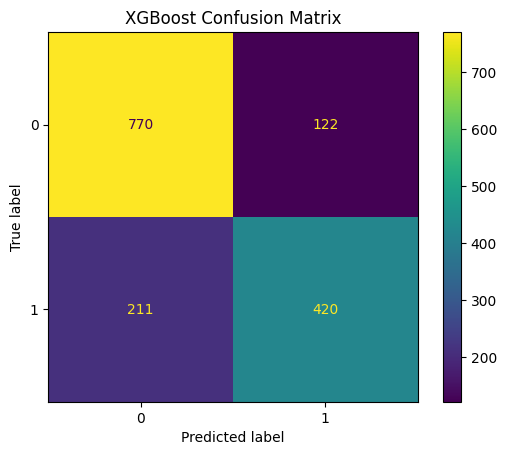

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test,xgbst_preds_val), display_labels=xgbst.classes_).plot()
plt.title('XGBoost Confusion Matrix')
plt.savefig('XGBoost_conf_matrix.png', dpi=200, bbox_inches='tight');

from google.colab import files
files.download("XGBoost_conf_matrix.png")

In [ ]:
xgbst_final = Pipeline([('tfidf', TfidfVectorizer(use_idf=False)),
 ('xgbst', XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=1000, sampling_method='uniform',
                         tree_method = 'hist', device='cuda', random_state=101))])
xgbst_final.fit(preprocessed_data, labels)

Pipeline(steps=[('tfidf', TfidfVectorizer(use_idf=False)),
                ('xgbst',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device='cuda',
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=1000, n_jobs=None,
                               num_parallel_tree=None, random_state=101, ...))])

#Sample predictions from test set

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving test_sample.csv to test_sample.csv


In [ ]:
import io

test_sample = pd.read_csv(io.BytesIO(uploaded['test_sample.csv']))
test_sample = test_sample.drop(['Unnamed: 0', 'Unnamed: 4','Unnamed: 3', 'Unnamed: 5', 'Unnamed: 6'],axis=1)
test_sample

,text,target
0,"Heard about #earthquake is different cities, s...",1
1,@Kayhow21 I may have a panic attack during thi...,0
2,Fire shuts down part of NJ Turnpike å_ 96 http...,1
3,'Sometimes I close my eyes and picture what th...,0
4,i survived what you tried to destroy you're no...,0
5,Green Line derailment in Chicago http://t.co/U...,1


In [ ]:
#Preprocess test tweets

tweet = test_sample['text']

for i in range(len(test_sample)):
  tweet[i] = re.sub('&amp', '&', tweet[i]) #turns '&amp to &'
  tweet[i] = re.sub(r'http\S+', '', tweet[i]) #removes links
  tweet[i] = re.sub(r'(@.*?)[\s]', ' ', tweet[i]) #removes mentions
  tweet[i] = re.sub(r'\s+', ' ', tweet[i]).strip() #removes trailing whitespace


stop_words = set(stopwords.words('english'))
stop_words.update(['http','https','via','...','..', "'s","'m"])
special_chars = set(string.punctuation)
lemmatizer = WordNetLemmatizer()

preprocessed_test_data = []

for i in range(len(test_sample)):
  tweet = test_sample['text'].iloc[i]
  tokens = word_tokenize(tweet.lower())
  filtered_tokens = [token for token in tokens if token.casefold() not in stop_words]
  filtered_tokens = [token for token in filtered_tokens if token not in special_chars]
  lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
  preprocessed_tweet = ' '.join(lemmatized_tokens)
  preprocessed_test_data.append(preprocessed_tweet)

In [ ]:
test_sample['cleaned text'] = preprocessed_test_data
test_sample = test_sample[['text','cleaned text','target']]
test_sample

,text,cleaned text,target
0,"Heard about #earthquake is different cities, s...",heard earthquake different city stay safe ever...,1
1,I may have a panic attack during this coinflip,may panic attack coinflip,0
2,Fire shuts down part of NJ Turnpike å_ 96,fire shuts part nj turnpike å_ 96,1
3,'Sometimes I close my eyes and picture what th...,'sometimes close eye picture world would like ...,0
4,i survived what you tried to destroy you're no...,survived tried destroy 're man boy,0
5,Green Line derailment in Chicago,green line derailment chicago,1


In [ ]:
svm_preds = svm_final.predict(test_sample['cleaned text'])
test_sample['svm preds'] = svm_preds
log_preds = log_final.predict(test_sample['cleaned text'])
test_sample['log preds'] = log_preds
knn_preds = knn_final.predict(test_sample['cleaned text'])
test_sample['knn preds'] = knn_preds
nbb_preds = nbb_final.predict(test_sample['cleaned text'])
test_sample['nbb preds'] = nbb_preds
rf_preds = rf_final.predict(test_sample['cleaned text'])
test_sample['rf preds'] = rf_preds
xgbst_preds = xgbst_final.predict(test_sample['cleaned text'])
test_sample['xgbst preds'] = xgbst_preds

In [ ]:
test_sample

,text,cleaned text,target,svm preds,log preds,knn preds,nbb preds,rf preds,xgbst preds
0,"Heard about #earthquake is different cities, s...",heard earthquake different city stay safe ever...,1,1,0,1,0,0,0
1,I may have a panic attack during this coinflip,may panic attack coinflip,0,0,0,0,0,0,0
2,Fire shuts down part of NJ Turnpike å_ 96,fire shuts part nj turnpike å_ 96,1,1,0,0,1,0,1
3,'Sometimes I close my eyes and picture what th...,'sometimes close eye picture world would like ...,0,0,1,1,0,0,0
4,i survived what you tried to destroy you're no...,survived tried destroy 're man boy,0,0,0,0,0,0,0
5,Green Line derailment in Chicago,green line derailment chicago,1,1,1,1,1,0,0


In [ ]:
test_sample['bert preds'] = [1, 0, 1, 0, 0, 1]
test_sample = test_sample.drop('best preds',axis=1)
test_sample

<ipython-input-37-a7e03f47707d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_sample['bert preds'] = [1, 0, 1, 0, 0, 1]


,text,cleaned text,target,svm preds,log preds,knn preds,nbb preds,rf preds,xgbst preds,bert preds
0,"Heard about #earthquake is different cities, s...",heard earthquake different city stay safe ever...,1,1,0,1,0,0,0,1
1,I may have a panic attack during this coinflip,may panic attack coinflip,0,0,0,0,0,0,0,0
2,Fire shuts down part of NJ Turnpike å_ 96,fire shuts part nj turnpike å_ 96,1,1,0,0,1,0,1,1
3,'Sometimes I close my eyes and picture what th...,'sometimes close eye picture world would like ...,0,0,1,1,0,0,0,0
4,i survived what you tried to destroy you're no...,survived tried destroy 're man boy,0,0,0,0,0,0,0,0
5,Green Line derailment in Chicago,green line derailment chicago,1,1,1,1,1,0,0,1


In [ ]:
test_sample.to_csv('sample_preds.csv')
from google.colab import files
files.download("sample_preds.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>